# Deploy fast.ai model with Amazon SageMaker
_**Hosting a fastai based Pre-Trained Model in Amazon SageMaker Algorithm Containers**_

## Prerequisites

Please make sure the IAM role associated with the SageMaker Notebook instance has the following managed policy attached so that you can push Docker images to ECS Container Registry.

```arn:aws:iam::aws:policy/AmazonEC2ContainerRegistryFullAccess```

## Background

Amazon SageMaker includes functionality to support a hosted notebook environment, distributed, managed training, and real-time hosting. We think it works best when all three of these services are used together, but they can also be used independently. Some use cases may only require hosting. Maybe the model was trained prior to Amazon SageMaker existing, in a different service.

This notebook shows how to use a pre-existing [fast.ai](https://github.com/fastai/fastai) based model with an Amazon SageMaker Algorithm container to quickly create a hosted endpoint for that model.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
bucket='sagemaker-mcclean-eu-west-1'          # customize to the name of your S3 bucket
model_file_name = 'fastai-dogscats-demo'      # customize to the name of your ECR repo
PATH='data/dogscats/'                         # customize to the relative location of your data folder
key='models/'+model_file_name+'/model.tar.gz' # prefix of the S3 bucket of the model file

In [3]:
import boto3
import re
import os
import urllib
import zipfile
import tarfile

## Downloading Training Dataset
For simplicity, we'll utilize the dataset that is part of [lesson 1](http://course.fast.ai/lessons/lesson1.html) of the fast.ai course. We will download the _dogscats_ image dataset from a Kaggle competition and save to a local directory.

In [4]:
%%time
if not os.path.isdir(PATH):
    print("Downloading data....")
    os.makedirs("data", exist_ok=True)
    zipfile_path = 'data/dogscats.zip'
    urllib.request.urlretrieve("http://files.fast.ai/data/dogscats.zip", zipfile_path)
    print("Extracting zipfile....")
    f = zipfile.ZipFile(zipfile_path)
    f.extractall("data")
    os.remove(zipfile_path)

Extracting zipfile....
CPU times: user 12.3 s, sys: 5.49 s, total: 17.8 s
Wall time: 1min 25s


## Train fastai model locally
Now we will train the fastai CNN model to distinguish between cats and dogs based on lesson 1 of the fast.ai course.

In [5]:
import torch
from fastai.imports import *

In [6]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [7]:
sz=224

In [8]:
torch.cuda.is_available()

True

In [9]:
torch.backends.cudnn.enabled

True

In [10]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

100%|██████████| 32/32 [00:05<00:00,  6.38it/s]


epoch      trn_loss   val_loss   accuracy                     
    0      0.040903   0.024878   0.99      
    1      0.041871   0.028731   0.9885                       



[array([0.02873]), 0.9885]

Now we can save our model so it can be used later by SageMaker using it as a model hosting service.

In [11]:
learn.save(model_file_name)

## Upload fastai model to S3
Now that we have trained a model and saved locally we can upload it plus some extra files to S3.

In [12]:
def get_relative_path(filename):
    s1 = os.path.split(filename)
    p = os.path.split(s1[0])[1]
    return os.path.join(p, s1[1])

In [13]:
def create_dummy_data(src_path, dest_root, sub_dir, num_items=2):
    if not os.path.isdir(dest_root): os.mkdir(dest_root)
    dst_path = os.path.join(dest_root, sub_dir)
    classes = os.listdir(src_path)
    for d in classes:
        if d.startswith('.'): continue
        if not os.path.isdir(dst_path): os.mkdir(dst_path)
        if not os.path.isdir(os.path.join(dst_path, d)): os.mkdir(os.path.join(dst_path, d))
        fnames = glob('{}/{}/*.jpg'.format(src_path, d))
        for i in range(num_items):
            shutil.copyfile(fnames[i], os.path.join(dst_path, get_relative_path(fnames[i])))

In [14]:
create_dummy_data(PATH + "train", PATH + "models/data", "train")
create_dummy_data(PATH + "valid", PATH + "models/data", "valid")

Now we will create a tarfile with the saved model and some dummy images from the train and validation data sets.

In [15]:
!tar czvf data/dogscats/model.tar.gz -C data/dogscats/models/ .

./
./data/
./data/train/
./data/train/dogs/
./data/train/dogs/dog.7361.jpg
./data/train/dogs/dog.1736.jpg
./data/train/cats/
./data/train/cats/cat.4488.jpg
./data/train/cats/cat.9192.jpg
./data/valid/
./data/valid/dogs/
./data/valid/dogs/dog.5643.jpg
./data/valid/dogs/dog.5704.jpg
./data/valid/cats/
./data/valid/cats/cat.7243.jpg
./data/valid/cats/cat.4894.jpg
./fastai-dogscats-demo.h5


Now we will upload the zipped model and example images to S3.

In [16]:
boto3.client('s3').upload_file(PATH+"model.tar.gz", bucket, key)

## Packaging and Uploading your Algorithm for use with Amazon SageMaker

### An overview of Docker

If you're familiar with Docker already, you can skip ahead to the next section.

For many data scientists, Docker containers are a new concept, but they are not difficult, as you'll see here. 

Docker provides a simple way to package arbitrary code into an _image_ that is totally self-contained. Once you have an image, you can use Docker to run a _container_ based on that image. Running a container is just like running a program on the machine except that the container creates a fully self-contained environment for the program to run. Containers are isolated from each other and from the host environment, so the way you set up your program is the way it runs, no matter where you run it.

Docker is more powerful than environment managers like conda or virtualenv because (a) it is completely language independent and (b) it comprises your whole operating environment, including startup commands, environment variable, etc.

In some ways, a docker container is like a virtual machine, but it is much lighter weight. For example, a program running in a container can start in less than a second and many containers can run on the same physical machine or virtual machine instance.

Docker uses a simple file called a `Dockerfile` to specify how the image is assembled. We'll see an example of that below. You can build your Docker images based on Docker images built by yourself or others, which can simplify things quite a bit.

Docker has become very popular in the programming and devops communities for its flexibility and well-defined specification of the code to be run. It is the underpinning of many services built in the past few years, such as [Amazon ECS].

Amazon SageMaker uses Docker to allow users to train and deploy arbitrary algorithms.

In Amazon SageMaker, Docker containers are invoked in a certain way for training and a slightly different way for hosting. The following sections outline how to build containers for the SageMaker environment.

Some helpful links:

* [Docker home page](http://www.docker.com)
* [Getting started with Docker](https://docs.docker.com/get-started/)
* [Dockerfile reference](https://docs.docker.com/engine/reference/builder/)
* [`docker run` reference](https://docs.docker.com/engine/reference/run/)

[Amazon ECS]: https://aws.amazon.com/ecs/

### How Amazon SageMaker runs your Docker container

Because you can run the same image in training or hosting, Amazon SageMaker runs your container with the argument `train` or `serve`. How your container processes this argument depends on the container:

* In the example here, we don't define an `ENTRYPOINT` in the Dockerfile so Docker will run the command `serve` at serving time. In this example, we define these as executable Python scripts, but they could be any program that we want to start in that environment.
* If you specify a program as an `ENTRYPOINT` in the Dockerfile, that program will be run at startup and its first argument will be `train` or `serve`. The program can then look at that argument and decide what to do.
* If you are building separate containers for training and hosting (or building only for one or the other), you can define a program as an `ENTRYPOINT` in the Dockerfile and ignore (or verify) the first argument passed in. 

#### Running your container during hosting

Hosting is reponding to inference requests that come in via HTTP. In this example, we use our recommended Python serving stack to provide robust and scalable serving of inference requests:

![Request serving stack](stack.png)

This stack is implemented in the sample code here and you can mostly just leave it alone. 

Amazon SageMaker uses two URLs in the container:

* `/ping` will receive `GET` requests from the infrastructure. Your program returns 200 if the container is up and accepting requests.
* `/invocations` is the endpoint that receives client inference `POST` requests. The format of the request and the response is up to the algorithm. If the client supplied `ContentType` and `Accept` headers, these will be passed in as well. 

The container will have the model files in the same place they were written during training:

    /opt/ml
    └── model
        └── <model files>

### The parts of the sample fast.ai container

In the `container` directory are all the components you need to package the sample algorithm for Amazon SageMager:

    .
    ├── Dockerfile
    ├── build_and_push.sh
    └── conv_net
        ├── nginx.conf
        ├── predictor.py
        ├── serve
        └── wsgi.py

Let's discuss each of these in turn:

* __`Dockerfile`__ describes how to build your Docker container image. More details below.
* __`build_and_push.sh`__ is a script that users the Dockerfile to build your container images and then pushes it to ECR. We'll invoke the commands directly later in this notebook, but you can just copy and run the script for your own algorithms.
* __`conv_net`__ is the directory which contains the files that will be installed in the container.
* __`local_test`__ is a directory that shows how to test your new container on any computer that can run Docker, including an Amazon SageMaker notebook instance. Using this method, you can quickly iterate using small datasets to eliminate any structural bugs before you use the container with Amazon SageMaker. We'll walk through local testing later in this notebook.

In this simple application, we only install a few files in the container. You may only need that many or, if you have many supporting routines, you may wish to install more. These five show the standard structure of our Python containers, although you are free to choose a different toolset and therefore could have a different layout. If you're writing in a different programming language, you'll certainly have a different layout depending on the frameworks and tools you choose.

The files that we'll put in the container are:

* __`nginx.conf`__ is the configuration file for the nginx front-end. Generally, you should be able to take this file as-is.
* __`predictor.py`__ is the program that actually implements the Flask web server and the fast.ai Convolutional Neural Network (CNN) trained earlier for this "dogscats" app. You'll want to customize the actual prediction parts to your application. Since this algorithm is simple, we do all the processing here in this file, but you may choose to have separate files for implementing your custom logic.
* __`serve`__ is the program started when the container is started for hosting. It simply launches the gunicorn server which runs multiple instances of the Flask app defined in `predictor.py`. You should be able to take this file as-is.
* __`wsgi.py`__ is a small wrapper used to invoke the Flask app. You should be able to take this file as-is.

In summary, the file you will probably want to change for your fast.ai application is `predictor.py`.

### The Dockerfile

The Dockerfile describes the image that we want to build. You can think of it as describing the complete operating system installation of the system that you want to run. A Docker container running is quite a bit lighter than a full operating system, however, because it takes advantage of Linux on the host machine for the basic operations. 

For the Python science stack, we will start from a standard Ubuntu installation and run the normal tools to install the things needed by the fastai library. Finally, we add the code that implements our specific algorithm to the container and set up the right environment to run under.

Along the way, we clean up extra space. This makes the container smaller and faster to start.

Let's look at the Dockerfile for the example:

In [17]:
!cat container/Dockerfile

FROM ubuntu:16.04

RUN apt-get update && apt-get install -y --allow-downgrades --no-install-recommends \
         build-essential \
         cmake \
         git \
         curl \
         vim \
         ca-certificates \
         python-qt4 \
         libjpeg-dev \
	       zip \
	       unzip \
         nginx \
         libpng-dev &&\
     rm -rf /var/lib/apt/lists/*

ENV PYTHON_VERSION=3.6
RUN curl -o ~/miniconda.sh -O  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh  && \
     chmod +x ~/miniconda.sh && \
     ~/miniconda.sh -b -p /opt/conda && \
     rm ~/miniconda.sh && \
    /opt/conda/bin/conda install conda-build

RUN git clone https://github.com/fastai/fastai.git
RUN cd fastai/ && ls && /opt/conda/bin/conda env create -f environment-cpu.yml
RUN /opt/conda/bin/conda clean -ya

ENV PATH /opt/conda/envs/fastai-cpu/bin:$PATH
ENV USER fastai

WORKDIR /fastai

CMD source activate fastai-cpu
CMD source ~/.bashrc

# Here we install the extra python packages to ru

### Building and registering the container

The following shell code shows how to build the container image using `docker build` and push the container image to ECR using `docker push`. This code is also available as the shell script `container/build-and-push.sh`, which you can run as `build-and-push.sh fastai-dogscats-demo` to build the image `fastai-dogscats-demo`. 

This code looks for an ECR repository in the account you're using and the current default region (if you're using a SageMaker notebook instance, this will be the region where the notebook instance was created). If the repository doesn't exist, the script will create it.

In [28]:
%%bash

# The name of our algorithm
algorithm_name=fastai-dogscats-demo

cd container

chmod +x conv_net/train
chmod +x conv_net/serve

account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
region=${region:-us-west-2}

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# If the repository doesn't exist in ECR, create it.

aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR
# with the full name.

# On a SageMaker Notebook Instance, the docker daemon may need to be restarted in order
# to detect your network configuration correctly.  (This is a known issue.)
if [ -d "/home/ec2-user/SageMaker" ]; then
  sudo service docker restart
fi

docker build  -t ${algorithm_name} .
docker tag ${algorithm_name} ${fullname}

docker push ${fullname}

Login Succeeded
Stopping docker: [  OK  ]
Starting docker:	.[  OK  ]

Step 1/20 : FROM ubuntu:16.04
 ---> f975c5035748
Step 2/20 : RUN apt-get update && apt-get install -y --allow-downgrades --no-install-recommends          build-essential          cmake          git          curl          vim          ca-certificates          python-qt4          libjpeg-dev 	       zip 	       unzip          nginx          libpng-dev &&     rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> c87cb421d986
Step 3/20 : ENV PYTHON_VERSION=3.6
 ---> Using cache
 ---> 09eb2343a197
Step 4/20 : RUN curl -o ~/miniconda.sh -O  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh  &&      chmod +x ~/miniconda.sh &&      ~/miniconda.sh -b -p /opt/conda &&      rm ~/miniconda.sh &&     /opt/conda/bin/conda install conda-build
 ---> Using cache
 ---> a6c7aed09c30
Step 5/20 : RUN git clone https://github.com/fastai/fastai.git
 ---> Using cache
 ---> da0928d8ef90
Step 6/20 : RUN cd fastai/ && ls && /

WARNING! Using --password via the CLI is insecure. Use --password-stdin.


## Testing your algorithm on your local machine or on an Amazon SageMaker notebook instance

While you're first packaging an algorithm use with Amazon SageMaker, you probably want to test it yourself to make sure it's working right. In the directory `container/local_test`, there is a framework for doing this. It includes some shell scripts for running and using the container and a directory structure that mimics the one outlined above.

The scripts are:

* `serve_local.sh`: Run this with the name of the image once you've trained the model and it should serve the model. It will run and wait for requests. Simply use the keyboard interrupt to stop it.
* `predict.sh`: Run this with the name of a payload file and (optionally) the HTTP content type you want. The content type will default to `text/csv`. For example, you can run `$ ./predict.sh payload.csv text/csv`.

The directories are set up to test the fastai dogscats sample CNN presented here.

## Setting up SageMaker role and ECR repo name

Let's now specify:

- The Elastic Container Registry (ECR) repository where the custom Docker image used for model inference will be stored.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [29]:
%%time
from time import gmtime, strftime
from sagemaker import get_execution_role

role = get_execution_role()

client = boto3.client("sts")
account_id = client.get_caller_identity()["Account"]
region_name = boto3.Session().region_name
print('AWS Account ID: {}'.format(account_id))
print('Region: {}'.format(region_name))

model_image = '{}.dkr.ecr.{}.amazonaws.com/{}:latest'.format(account_id, region_name, model_file_name)

print('Docker image for inference is: {}'.format(model_image))
print('IAM role for SageMaker: {}'.format(role))


AWS Account ID: 934676248949
Region: eu-west-1
Docker image for training is: 934676248949.dkr.ecr.eu-west-1.amazonaws.com/fastai-dogscats-demo:latest
IAM role for SageMaker: arn:aws:iam::934676248949:role/service-role/AmazonSageMaker-ExecutionRole-20171203T194740
CPU times: user 132 ms, sys: 4 ms, total: 136 ms
Wall time: 764 ms


## Create Model

We now create a SageMaker Model from the training output. Using the model we can create an Endpoint Configuration.

In [31]:
%%time
from time import gmtime, strftime

model_name = model_file_name + '-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
model_url = 'https://s3-{}.amazonaws.com/{}/{}'.format(region_name,bucket,key)
sm_client = boto3.client('sagemaker')

print (model_url)

primary_container = {
    'Image': model_image,
    'ModelDataUrl': model_url,
}

create_model_response2 = sm_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response2['ModelArn'])

https://s3-eu-west-1.amazonaws.com/sagemaker-mcclean-eu-west-1/models/fastai-dogscats-demo/model.tar.gz
arn:aws:sagemaker:eu-west-1:934676248949:model/fastai-dogscats-demo2018-04-11-20-56-47
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 251 ms


## Create the Endpoint Configuration

Now we can create the Endpoint configuration to deploy the model for inference.

In [45]:
%%time
from time import gmtime, strftime

endpoint_config_name = model_file_name + '-endpoint-config-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.c5.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

fastai-dogscats-demo-endpoint-config-2018-04-11-21-23-55
Endpoint Config Arn: arn:aws:sagemaker:eu-west-1:934676248949:endpoint-config/fastai-dogscats-demo-endpoint-config-2018-04-11-21-23-55
CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 111 ms


## Create the Endpoint

Now we can create the endpoint to do the model inference.

In [46]:
%%time
import time

endpoint_name = model_file_name + '-endpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

try:
    sm_client.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)
finally:
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Arn: " + resp['EndpointArn'])
    print("Create endpoint ended with status: " + status)

    if status != 'InService':
        message = sm_client.describe_endpoint(EndpointName=endpoint_name)['FailureReason']
        print('Training failed with the following error: {}'.format(message))
        raise Exception('Endpoint creation did not succeed')

fastai-dogscats-demo-endpoint-2018-04-11-21-24-00
arn:aws:sagemaker:eu-west-1:934676248949:endpoint/fastai-dogscats-demo-endpoint-2018-04-11-21-24-00
Status: Creating
Arn: arn:aws:sagemaker:eu-west-1:934676248949:endpoint/fastai-dogscats-demo-endpoint-2018-04-11-21-24-00
Create endpoint ended with status: InService
CPU times: user 112 ms, sys: 40 ms, total: 152 ms
Wall time: 7min 31s


## Randomly select test image
Randomly select an image from the test folder to submit to the SageMaker prediction endpoint.

data/dogscats/test1/10740.jpg


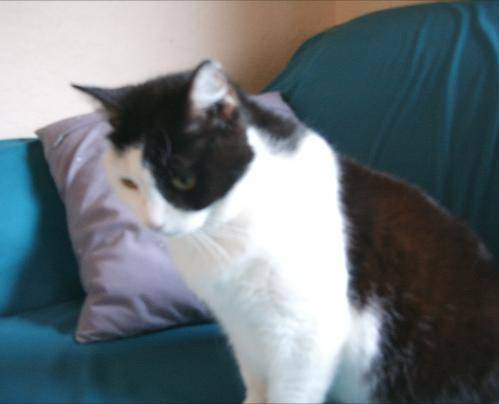

In [57]:
import os, random
dir_name = 'data/dogscats/test1/'
file_name = dir_name + random.choice(os.listdir(dir_name)) #change dir name to whatever
print(file_name)
#file_name = 'data/dogscats/test1/9969.jpg'
# test image
from IPython.display import Image
Image(file_name)

## Call Endpoint
Call the endpoint with some test data.

In [58]:
%%time
import time
import json

runtime = boto3.Session().client('runtime.sagemaker')

with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)
result = response['Body'].read()
print(json.loads(result))

{'result': {'class': 'cats', 'confidence': 0.32065349817276}}
CPU times: user 20 ms, sys: 8 ms, total: 28 ms
Wall time: 177 ms


## Delete Endpoint
Delete the endpoint to stop incurring costs.

In [59]:
import sagemaker as sage

sess = sage.Session()
sess.delete_endpoint(endpoint_name)

INFO:sagemaker:Deleting endpoint with name: fastai-dogscats-demo-endpoint-2018-04-11-21-24-00
